
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### 1: Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2: Load and Explore the NER Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [3]:
data = pd.read_csv('drive/My Drive/ner_dataset.csv', encoding='latin1')
data = data.fillna(method = 'ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [4]:
print(f'Number of unique words in data: {data.Word.nunique()}, number of unique tags: {data.Tag.nunique()}')

Number of unique words in data: 35178, number of unique tags: 17


In [5]:
words = list(set(data.Word.values))
words.append('ENDPAD')
num_words = len(words)

tags = list(set(data.Tag.values))
num_tags = len(tags)

num_words, num_tags

(35179, 17)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


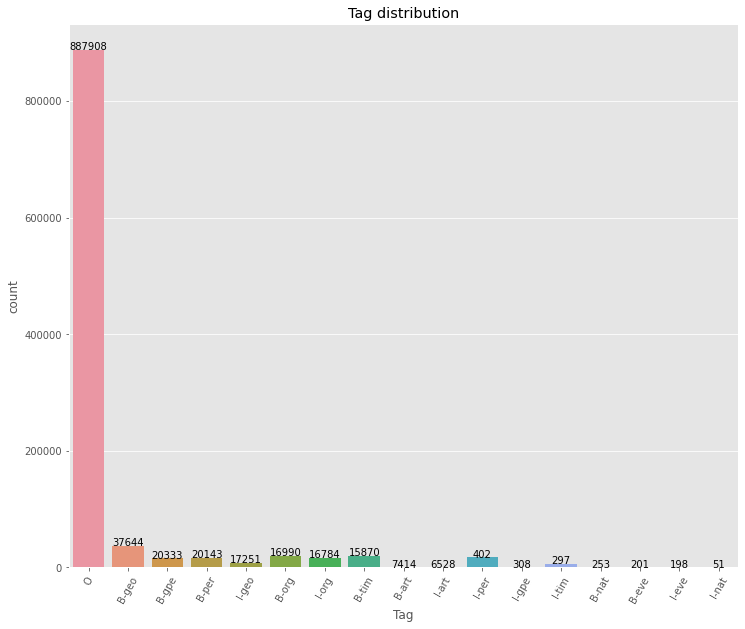

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
values = data.Tag.value_counts().values
plt.figure(figsize=(12, 10))
ax = sns.countplot(data.Tag, label='Count')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, values[i], ha='center')
    
plt.xticks(rotation=60)
plt.title('Tag distribution')
plt.show();

### 3: Retrieve Sentences and Corresponsing Tags

In [12]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        

In [13]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences), data['Sentence #'].nunique()

(47959, 47959)

In [14]:
sentences[-1]

[('The', 'DT', 'O'),
 ('United', 'NNP', 'B-org'),
 ('Nations', 'NNP', 'I-org'),
 ('is', 'VBZ', 'O'),
 ('praising', 'VBG', 'O'),
 ('the', 'DT', 'O'),
 ('use', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('military', 'JJ', 'O'),
 ('helicopters', 'NNS', 'O'),
 ('to', 'TO', 'O'),
 ('drop', 'VB', 'O'),
 ('food', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('rescue', 'NN', 'O'),
 ('survivors', 'NNS', 'O'),
 ('in', 'IN', 'O'),
 ('tsunami-ravaged', 'JJ', 'B-tim'),
 ('Indonesia', 'NNP', 'I-tim'),
 (',', ',', 'O'),
 ('saying', 'VBG', 'O'),
 ('the', 'DT', 'O'),
 ('aircraft', 'NN', 'O'),
 ('are', 'VBP', 'O'),
 ('"', '``', 'O'),
 ('worth', 'IN', 'O'),
 ('their', 'PRP$', 'O'),
 ('weight', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('gold', 'NN', 'O'),
 ('.', '.', 'O'),
 ('"', '``', 'O')]

### 4: Define Mappings between Sentences and Tags

In [15]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i+1 for i, t in enumerate(tags)}

### 5: Padding Input Sentences, Train/Test Splits

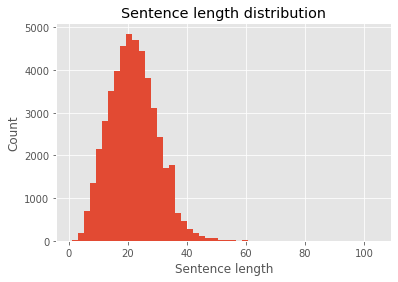

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Sentence length distribution')
plt.xlabel('Sentence length')
plt.ylabel('Count')
plt.show();

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 60
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen= max_len, sequences=y, padding = 'post', value=tag2idx['O'])
y = [to_categorical(i-1, num_classes=num_tags) for i in y]

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### 6: Build and Compile a Bidirectional LSTM Model

In [20]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [21]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 60)            2110740   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 60)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           128800    
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 17)            3417      
Total params: 2,242,957
Trainable params: 2,242,957
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam', 
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

### 7: Train the Model

In [24]:
!pip install livelossplot

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [32]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping] #, PlotLossesCallback()]

history = model.fit(x_train, np.array(y_train), 
                   validation_split=0.2,
                   batch_size=32,
                   epochs=15,
                   verbose=1,
                   callbacks=callbacks)

Epoch 1/15
1080/1080 [==============================] - 422s 391ms/step - loss: 0.1606 - accuracy: 0.9642 - val_loss: 0.0554 - val_accuracy: 0.9842
Epoch 2/15
1080/1080 [==============================] - 422s 390ms/step - loss: 0.0433 - accuracy: 0.9873 - val_loss: 0.0420 - val_accuracy: 0.9873
Epoch 3/15
1080/1080 [==============================] - 418s 387ms/step - loss: 0.0314 - accuracy: 0.9904 - val_loss: 0.0393 - val_accuracy: 0.9880
Epoch 4/15
1080/1080 [==============================] - 418s 387ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.0395 - val_accuracy: 0.9882
Epoch 5/15
1080/1080 [==============================] - 412s 381ms/step - loss: 0.0220 - accuracy: 0.9929 - val_loss: 0.0407 - val_accuracy: 0.9878


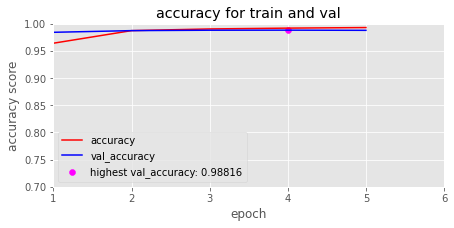

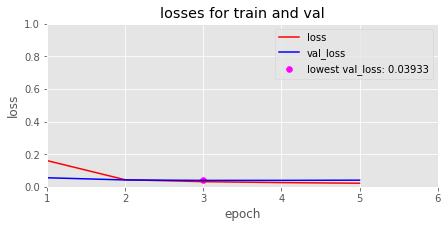

In [40]:
def plot_accuracy(history, title=f'accuracy for train and val'):
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(1, len(history.history['accuracy'])+ 1), history.history['accuracy'],'r', label='accuracy')
    plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'],'b', label = 'val_accuracy')
    best_val_acc = round(max(history.history['val_accuracy']), 5)
    plt.scatter(np.argmax(list(history.history['val_accuracy']))+1, max(history.history['val_accuracy']), c='magenta',
               label=f'highest val_accuracy: {best_val_acc}')
    plt.xlabel('epoch')
    plt.ylabel('accuracy score')
    plt.ylim([0.7, 1])
    plt.xlim([1, len(history.history['accuracy'])+1])
    plt.title(title)
    plt.legend()
    plt.show()


def plot_loss(history, title=f'losses for train and val'):
    plt.figure(figsize=(7,3))
    plt.plot(np.arange(1, len(history.history['loss'])+ 1), history.history['loss'],'r', label='loss')
    plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'],'b', label = 'val_loss')
    best_val_loss = round(min(history.history['val_loss']), 5)
    plt.scatter(np.argmin(list(history.history['val_loss']))+1, min(history.history['val_loss']), c='magenta',
               label=f'lowest val_loss: {best_val_loss}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim([0, 1])
    plt.xlim([1, len(history.history['loss'])+1])
    plt.title(title)
    plt.legend()
    plt.show()


plot_accuracy(history)
plot_loss(history)

### 8: Evaluate Named Entity Recognition Model

In [41]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 35ms/step - loss: 0.0413 - accuracy: 0.9876


[0.0413159504532814, 0.9875799417495728]

In [42]:
i = np.random.randint(0, len(x_test)-1)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test)[i], axis=-1)
print('{:15}{:5}\t {}\n'.format("Word", "True", "Pred"))
print('_'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

______________________________
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
and            O	O
the            O	O
European       B-org	B-org
Union          I-org	I-org
denounced      O	O
the            O	O
arrests        O	O
,              O	O
and            O	O
enacted        O	O
a              O	O
visa           O	O
ban            O	O
on             O	O
President      B-per	B-per
Lukashenko     I-per	I-per
and            O	O
other          O	O
top            O	O
Belarus        B-org	B-geo
officials      O	O
to             O	O
protest        O	O
the            O	O
fraud          O	O
.              O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preserved O	O
well-preser